In [15]:
import os, json, pickle, random, torch
import shutil
import torch.utils.data
from PIL import Image

In [16]:
# Installing the dependencies
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

# Load the model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

# Encode all the food categories to be used by the model
# Load all food categories
cats = ['Apple pie', 'Baby back ribs', 'Baklava', 'Beef carpaccio', 'Beef tartare', 
        'Beet salad', 'Beignets', 'Bibimbap', 'Bread pudding', 'Breakfast burrito', 
        'Bruschetta', 'Caesar salad', 'Cannoli', 'Caprese salad', 'Carrot cake', 'Ceviche', 
        'Cheese plate', 'Cheesecake', 'Chicken curry', 'Chicken quesadilla', 'Chicken wings', 
        'Chocolate cake', 'Chocolate mousse', 'Churros', 'Clam chowder', 'Club sandwich', 
        'Crab cakes', 'Creme brulee', 'Croque madame', 'Cup cakes', 'Deviled eggs', 'Donuts', 
        'Dumplings', 'Edamame', 'Eggs benedict', 'Escargots', 'Falafel', 'Filet mignon', 
        'Fish and chips', 'Foie gras', 'French fries', 'French onion soup', 'French toast', 
        'Fried calamari', 'Fried rice', 'Frozen yogurt', 'Garlic bread', 'Gnocchi', 'Greek salad', 
        'Grilled cheese sandwich', 'Grilled salmon', 'Guacamole', 'Gyoza', 'Hamburger', 
        'Hot and sour soup', 'Hot dog', 'Huevos rancheros', 'Hummus', 'Ice cream', 'Lasagna', 
        'Lobster bisque', 'Lobster roll sandwich', 'Macaroni and cheese', 'Macarons', 'Miso soup', 
        'Mussels', 'Nachos', 'Omelette', 'Onion rings', 'Oysters', 'Pad thai', 'Paella', 
        'Pancakes', 'Panna cotta', 'Peking duck', 'Pho', 'Pizza', 'Pork chop', 'Poutine', 
        'Prime rib', 'Pulled pork sandwich', 'Ramen', 'Ravioli', 'Red velvet cake', 'Risotto', 
        'Samosa', 'Sashimi', 'Scallops', 'Seaweed salad', 'Shrimp and grits', 'Spaghetti bolognese', 
        'Spaghetti carbonara', 'Spring rolls', 'Steak', 'Strawberry shortcake', 'Sushi', 'Tacos', 
        'Takoyaki', 'Tiramisu', 'Tuna tartare', 'Waffles']
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

In [29]:
def predict_food(image, cats, model, preprocess, text_features):
    """
    Predicts the top 3 classification predictions for an input image
        Input:  img: RGB PIL.Image.Image file
                cats: Food categories (From previous cell)
                model: CLIP model (From previous cell)
                preprocess: CLIP model preprocessing tools (From previous cell)
                text_features: Encoded output categories to be used as predictors (From previous cell)
                
        Output: List of top 3 food class predictions (ordered)
    """
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    
    with torch.no_grad():
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)
        
    # Compute the predictions
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    score, pred_id = similarity[0].topk(3)
    
    predictions = [cats[idx] for idx in list(pred_id)]
    score.tolist()
    output = []
    for i in range(len(score)):
        output.append((predictions[i], round(float(score[i]), 3)))
    return output

Predictions: [('Pizza', 0.951), ('Garlic bread', 0.013), ('Grilled cheese sandwich', 0.005)]


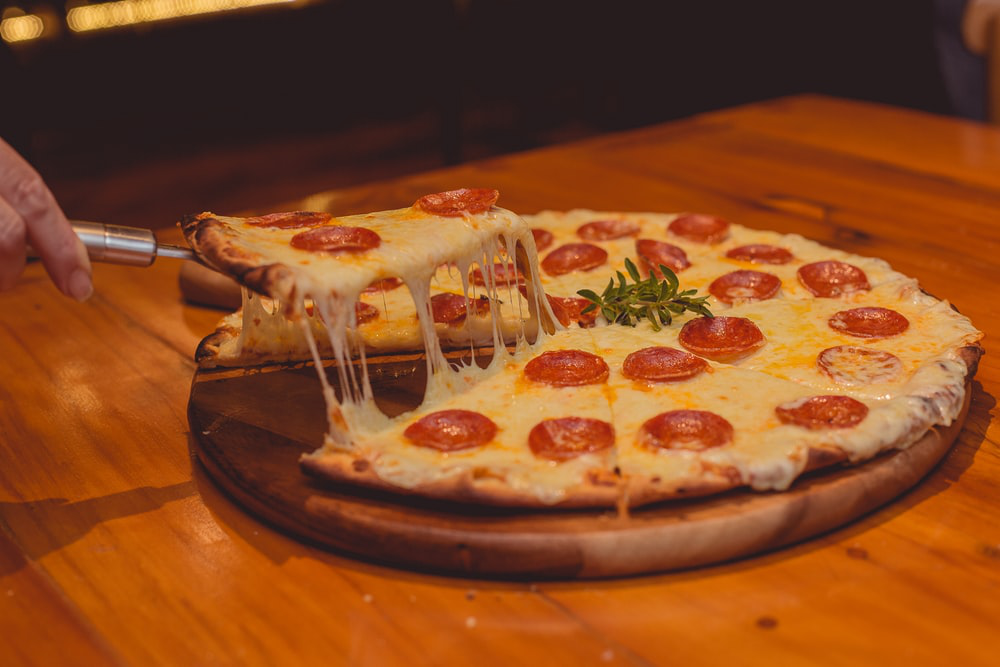

In [30]:
# Test code that does not use the data loader 
file_path = '69696969.jpeg'
image = Image.open(file_path).convert('RGB')
outputs = predict_food(image, cats, model, preprocess, text_features)
print('Predictions: {}'.format(outputs))
image
